In [1]:
using Images, ImageFiltering, FileIO, ImageView, ImageMorphology, ColorTypes, ImageDraw, Colors

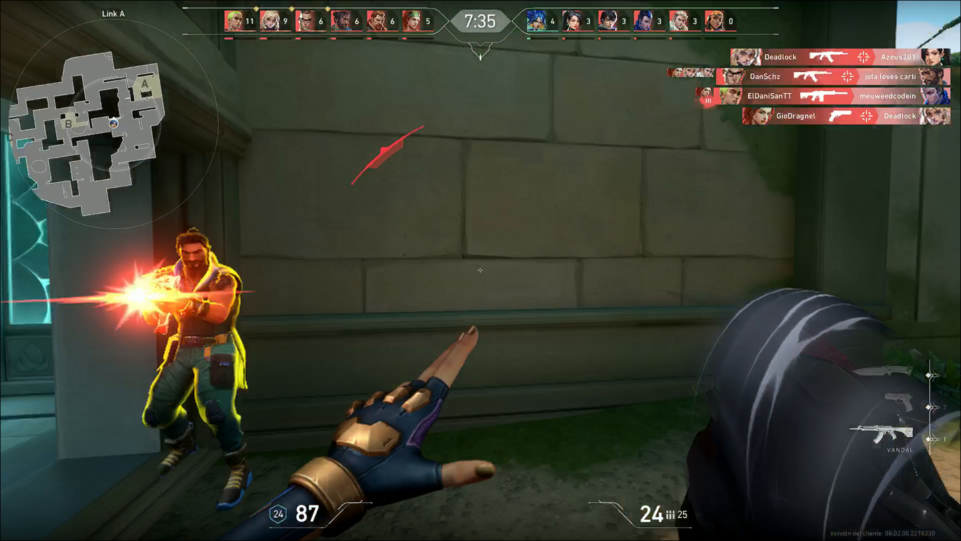

In [2]:
img = load("Frames/edition1/frame23_194.png")

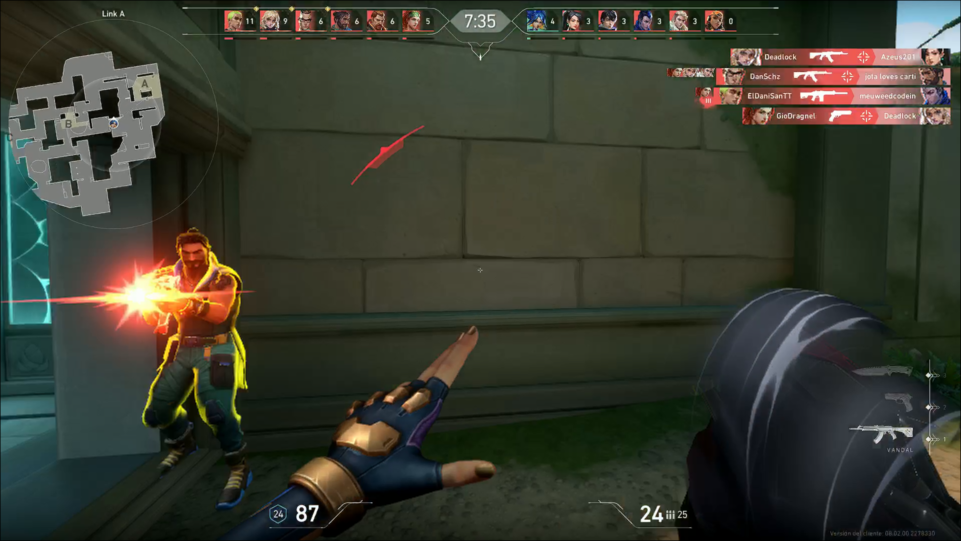

In [3]:
img_hsv = HSV.(img)

In [4]:
# Define the yellow color range in HSV, ensuring the type matches img_hsv pixels
yellow_low = HSV{Float32}(40, 100/255, 155/255)


In [5]:
yellow_high = HSV{Float32}(71, 255/255, 255/255)

In [6]:
mask = map(img_hsv) do pixel
    h, s, v = pixel.h, pixel.s, pixel.v
    h_low, s_low, v_low = yellow_low.h, yellow_low.s, yellow_low.v
    h_high, s_high, v_high = yellow_high.h, yellow_high.s, yellow_high.v

    h_in_range = h_low <= h <= h_high
    s_in_range = s_low <= s <= s_high
    v_in_range = v_low <= v <= v_high

    return h_in_range && s_in_range && v_in_range ? 1 : 0
end

1080×1920 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  

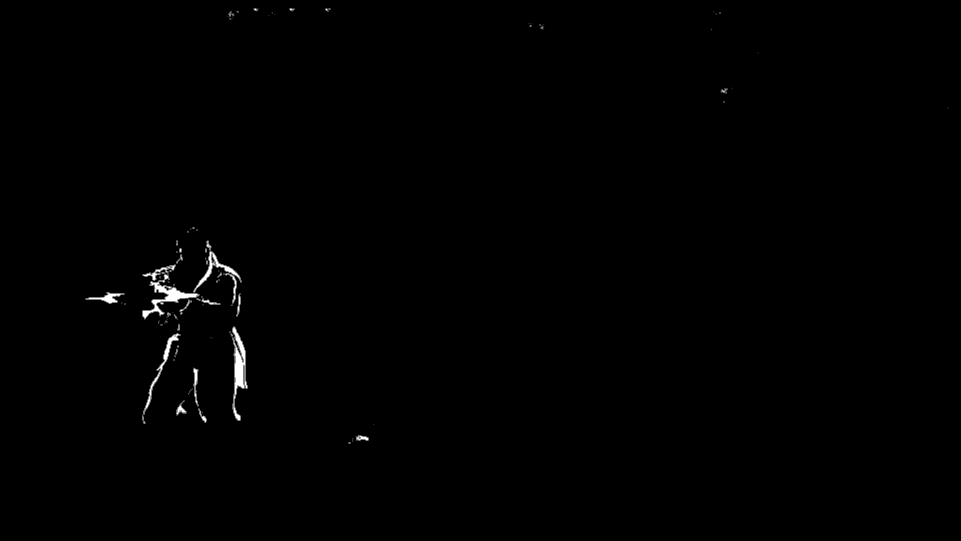

In [7]:
# Convert mask to grayscale image for morphological operations
mask_gray = Gray.(mask)

In [8]:
se = centered(Bool[
    0 0 1 1 1 0 0
    0 1 1 1 1 1 0
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    0 1 1 1 1 1 0
    0 0 1 1 1 0 0
])

se2 = centered(Bool[
    0 0 1 0 0  
    0 1 1 1 0  
    1 1 1 1 1  
    0 1 1 1 0 
    0 0 1 0 0 
])

5×5 OffsetArray(::Matrix{Bool}, -2:2, -2:2) with eltype Bool with indices -2:2×-2:2:
 0  0  1  0  0
 0  1  1  1  0
 1  1  1  1  1
 0  1  1  1  0
 0  0  1  0  0

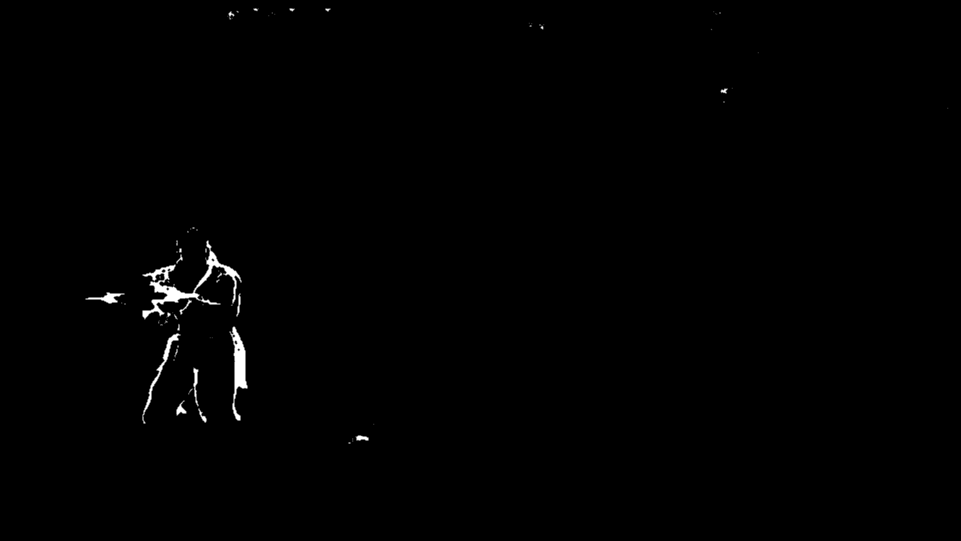

In [9]:
#img_erode = @. Gray(mask_gray < 0.1); # keeps white objects white
img_erosion1 = closing(mask_gray,se2)

In [10]:

function bounding_boxes(mask::Array{T, 2}) where {T}
    # Encontrar los objetos en la máscara binaria
    objects = label_components(mask)
    
    # Inicializar un vector para almacenar los bounding boxes de cada objeto
    bounding_boxes_list = Tuple[]
    
    # Iterar sobre cada objeto y calcular su bounding box
    for obj in 1:maximum(objects)
        # Crear una máscara para el objeto actual
        obj_mask = objects .== obj
        
        # Encontrar los índices de los píxeles no negros en la máscara del objeto
        non_black_pixels = findall(!isequal(zero(T)), obj_mask)
        
        # Calcular coordenadas mínimas y máximas de los píxeles no negros
        min_x = minimum(i[2] for i in non_black_pixels)
        max_x = maximum(i[2] for i in non_black_pixels)
        min_y = minimum(i[1] for i in non_black_pixels)
        max_y = maximum(i[1] for i in non_black_pixels)
        
        # Agregar el bounding box a la lista
        push!(bounding_boxes_list, (min_x, min_y, max_x, max_y))
    end
    
    # Devolver la lista de bounding boxes
    return bounding_boxes_list
end

bounding_boxes (generic function with 1 method)

In [11]:
bbox = bounding_boxes(img_erosion1)


97-element Vector{Tuple}:
 (171, 585, 248, 606)
 (243, 605, 243, 606)
 (249, 607, 250, 608)
 (285, 481, 482, 638)
 (285, 667, 360, 846)
 (317, 643, 317, 646)
 (318, 641, 318, 641)
 (319, 553, 320, 554)
 (320, 556, 320, 556)
 (321, 649, 324, 650)
 ⋮
 (1431, 27, 1431, 27)
 (1433, 28, 1433, 28)
 (1439, 25, 1440, 26)
 (1441, 177, 1454, 186)
 (1442, 185, 1442, 185)
 (1447, 203, 1448, 204)
 (1464, 176, 1464, 176)
 (1516, 105, 1516, 105)
 (1895, 216, 1895, 216)

In [12]:
function merge_close_bounding_boxes(bounding_boxes_list::Vector{T}, threshold::Real) where T<:Tuple
    # Creamos una copia de la lista original de bounding boxes para no modificarla directamente
    merged_boxes = deepcopy(bounding_boxes_list)
    
    # Bandera para indicar si se han realizado fusiones
    merged = true
    
    # Iteramos hasta que no haya más fusiones
    while merged
        merged = false
        
        # Iteramos sobre cada par de bounding boxes
        for i in 1:length(merged_boxes)-1
            for j in i+1:length(merged_boxes)
                box1 = merged_boxes[i]
                box2 = merged_boxes[j]
                
                # Calculamos la distancia entre los centros de las bounding boxes
                center1 = ((box1[1] + box1[3]) / 2, (box1[2] + box1[4]) / 2)
                center2 = ((box2[1] + box2[3]) / 2, (box2[2] + box2[4]) / 2)
                distance = sqrt((center1[1] - center2[1])^2 + (center1[2] - center2[2])^2)
                
                # Si la distancia es menor que el umbral, fusionamos las bounding boxes
                if distance < threshold
                    merged_boxes[i] = (min(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3]), max(box1[4], box2[4]))
                    deleteat!(merged_boxes, j)
                    merged = true
                    break
                end
            end
            
            if merged
                break
            end
        end
    end
    
    return merged_boxes
end


merge_close_bounding_boxes (generic function with 1 method)

In [13]:
function print_merged_bounding_boxes(merged_boxes::Vector{T}) where T<:Tuple
    for (i, bbox) in enumerate(merged_boxes)
        println("Bounding Box $i: ", bbox)
    end
end


print_merged_bounding_boxes (generic function with 1 method)

In [14]:
# Definir umbral de proximidad para la fusión de bounding boxes (ajusta este valor según tus necesidades)
threshold = 100  # Por ejemplo
threshold2 = 100
# Fusionar las bounding boxes cercanas
merged_boxes = merge_close_bounding_boxes(bbox, threshold)


# Imprimir las bounding boxes fusionadas
#print_merged_bounding_boxes(merged_boxes)

14-element Vector{Tuple}:
 (171, 585, 250, 608)
 (285, 481, 482, 660)
 (285, 667, 412, 846)
 (375, 455, 394, 464)
 (420, 653, 494, 840)
 (455, 17, 588, 38)
 (473, 587, 480, 632)
 (651, 17, 660, 22)
 (697, 848, 747, 886)
 (1058, 46, 1087, 58)
 (1422, 23, 1440, 59)
 (1441, 176, 1464, 204)
 (1516, 105, 1516, 105)
 (1895, 216, 1895, 216)

In [15]:
function draw_bounding_boxes(bounding_boxes_list::Vector{T}, img, color) where T<:Tuple
    img2=deepcopy(img)
    for i in 1:length(bounding_boxes_list)
        x1,y1,x2,y2=bounding_boxes_list[i]
        for x in x1:x2
            img2[y1,x]=color
            img2[y2,x]=color
        end
        for y in y1:y2
            img2[y, x1] = color
            img2[y, x2] = color
        end
    end
    return img2   
end

draw_bounding_boxes (generic function with 1 method)

In [16]:
function reduce_bounding_boxes(bounding_boxes_list::Vector{T}, threshold) where T<:Tuple
    copy_list= copy(bounding_boxes_list)
    counter=0
    for i in 1:length(bounding_boxes_list)
        x1,y1,x2,y2=bounding_boxes_list[i]
        height = y2-y1
        width = x2-x1
        x_proportion=width ./ height
        if ((height<threshold && width<threshold) || x_proportion>5 || x_proportion<0.2)
            deleteat!(copy_list, i-counter)
            counter=counter+1

        end
    end
    return copy_list
end
            
        

reduce_bounding_boxes (generic function with 1 method)

In [17]:
reduced_boxes= reduce_bounding_boxes(merged_boxes,15)


9-element Vector{Tuple}:
 (171, 585, 250, 608)
 (285, 481, 482, 660)
 (285, 667, 412, 846)
 (375, 455, 394, 464)
 (420, 653, 494, 840)
 (697, 848, 747, 886)
 (1058, 46, 1087, 58)
 (1422, 23, 1440, 59)
 (1441, 176, 1464, 204)

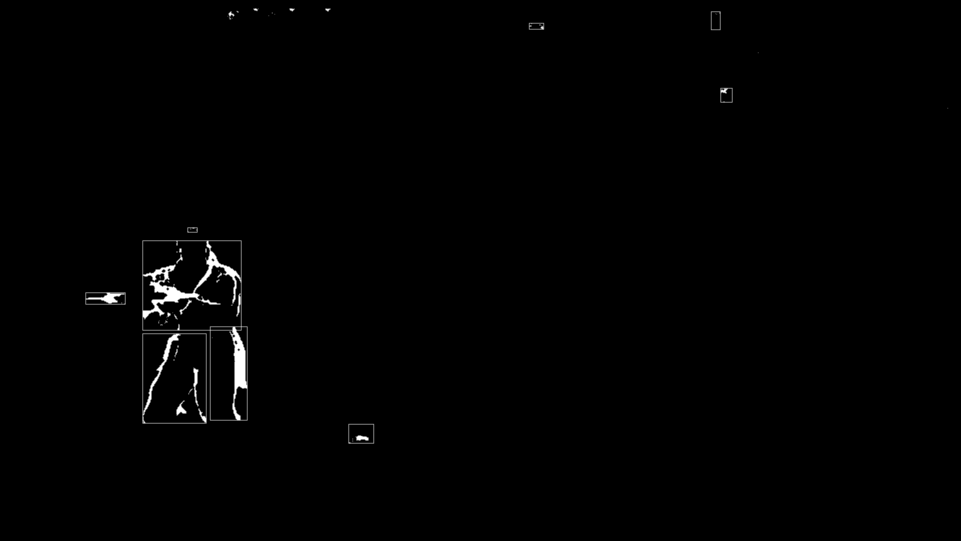

In [18]:
img_bound = draw_bounding_boxes(reduced_boxes, img_erosion1, 1)

In [20]:
function join_near_bounding_boxes(bounding_boxes_list::Vector{T}, threshold) where T<:Tuple
    #funcion para unir bounding boxes una vez realizado el primer batch de bounding
    #la funcion une en base al threshold los bounding que se sobrepongan o cuyos bordes esten a una distancia menor que el threshold

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\david\Documents\AA\AA\AA\contornos.ipynb:2:84
function join_near_bounding_boxes(bounding_boxes_list::Vector{T}, threshold) where T<:Tuple
    #funcion para unir bounding boxes una vez realizado el primer batch de bounding
#                                                                                  └ ── premature end of input